# Model 5: Multiingual comments sentiment classifier

To build a multilingual sentiment classifier, we will use a pre-trained model that has been trained on a large multilingual corpus. I found a model on hugging face, this model is ideal for classifying comments. The model is called tabularisai/multilingual-sentiment-analysis\
Link: https://huggingface.co/tabularisai/multilingual-sentiment-analysis

I already transformed and collected data in one dataset in `multi_datasets_collection.ipynb` notebook. So one think we need to do is prepare data for the model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from transformers import get_scheduler
from tqdm import tqdm

## Load Dataset

In [ ]:
# import requests

# # Replace with the file ID from the Google Drive public URL
# file_id = ""
# url = f"https://drive.usercontent.google.com/download?id={file_id}&export=download&confirm=t"

# # Download the file
# response = requests.get(url)
# if response.status_code == 200:
#     with open("./data/data.csv", "wb") as f:
#         f.write(response.content)
#     print("File downloaded successfully.")
# else:
#     print("Failed to download the file. Status code:", response.status_code)

In [ ]:
data = pd.read_csv('../../data/Multiilingual_dataset/mulilingual_dataset.csv')
data = data.dropna()
data = data.sample(frac=0.5, random_state=42) # Lack of computational resources

In [ ]:
data["label"].value_counts()

label
1.0    445219
0.0    342570
2.0    166118
Name: count, dtype: int64

In [ ]:
# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data["text"].tolist(), data["label"].tolist(), test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

## Load the Pre-trained Model & Tokenizer

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)  

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at tabularisai/multilingual-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize dataset

In [ ]:
def tokenize_function(texts):
    tokenized_texts = []
    for text in tqdm(texts, desc="Tokenizing Texts", unit="text"):
        tokenized_texts.append(tokenizer(text, truncation=True, padding="max_length", max_length=128))
    return {key: [dic[key] for dic in tokenized_texts] for key in tokenized_texts[0]}  

In [ ]:
train_encodings = tokenize_function(train_texts)

Tokenizing Texts: 100%|██████████| 763125/763125 [03:42<00:00, 3425.22text/s]


In [ ]:
val_encodings = tokenize_function(val_texts)

Tokenizing Texts: 100%|██████████| 95391/95391 [00:35<00:00, 2657.20text/s]


In [ ]:
test_encodings = tokenize_function(test_texts)

Tokenizing Texts: 100%|██████████| 95391/95391 [00:34<00:00, 2757.33text/s]


## Create a PyTorch Dataset Class

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are long tensors
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

##  Set Up DataLoaders for Training

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train loop 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
)

def train_model():
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc="Training", leave=True)
    for batch in loop:
        optimizer.zero_grad()

        # Move data to GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

## Evaluate the model

In [ ]:
def evaluate_model():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        loop = tqdm(val_loader, desc="Validating", leave=True)
        for batch in loop:
            # Move data to GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [ ]:
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_model()
    val_loss, val_acc = evaluate_model()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

Epoch 1/3


Validating: 100%|██████████| 2981/2981 [02:48<00:00, 17.68it/s, loss=0.801]


Train Loss: 0.6840 | Val Loss: 0.6444 | Val Accuracy: 0.6906
Epoch 2/3


Validating: 100%|██████████| 2981/2981 [02:51<00:00, 17.35it/s, loss=0.801]


Train Loss: 0.5971 | Val Loss: 0.6280 | Val Accuracy: 0.7024
Epoch 3/3


Validating: 100%|██████████| 2981/2981 [02:48<00:00, 17.66it/s, loss=0.937]

Train Loss: 0.5106 | Val Loss: 0.6478 | Val Accuracy: 0.7067


## Save, load and test the model

### Save the fine-tuned model

In [ ]:
save_directory = "model5"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print("Model and tokenizer saved!")


### Load the saved model

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "model5"
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

### Test the model on a new sentence

In [4]:
def predict_sentiment(text):
    loaded_model.eval()
    
    # Tokenize input text
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move to device
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class  

In [5]:
new_sentence = "Ten film jest niesamowity! Uwielbiam go."
predicted_label = predict_sentiment(new_sentence)

print(f"Predicted Sentiment Label: {predicted_label}")

Predicted Sentiment Label: 2


## Evaluate the model

In [7]:
data = pd.read_csv('../../data/Multiilingual_dataset/mulilingual_dataset.csv').dropna()
before_data = data.sample(frac=0.5, random_state=42)
remaining_data = data.drop(before_data.index)

In [8]:
new_data = remaining_data.sample(frac=0.1, random_state=42)
len(new_data)

95391

In [11]:
from tqdm import tqdm
tqdm.pandas(desc="Processing Sentiment Analysis")
new_data["predicted_label"] = new_data["text"].progress_apply(predict_sentiment)

Processing Sentiment Analysis: 100%|██████████| 95391/95391 [09:36<00:00, 165.38it/s]


Model classified 100000 comments for 10 minutes, what is good result.

In [12]:
new_data.isna().sum()

text               0
label              0
predicted_label    0
dtype: int64

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(new_data['label'], new_data['predicted_label'])
class_report = classification_report(new_data['label'], new_data['predicted_label'], target_names=['Negative', 'Neutral', 'Positive'])

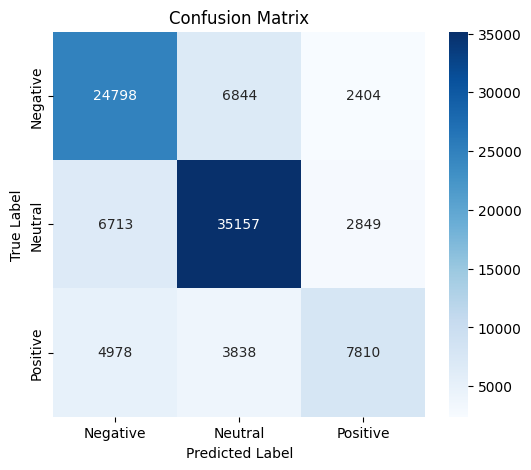

In [14]:
# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Display classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.73      0.70     34046
     Neutral       0.77      0.79      0.78     44719
    Positive       0.60      0.47      0.53     16626

    accuracy                           0.71     95391
   macro avg       0.68      0.66      0.67     95391
weighted avg       0.71      0.71      0.71     95391



F1 score for positive is much less than for negative and neutral. It is because of the sampled imbalanced dataset. So it is better to train the saved model on the more balanced dataset, with more proportionate representation. Also optional is to use in data some percent of data that model saw during training because it other way model could forget the data on which it was trained on. So let's try to train the model on the more balanced dataset and check the results.